In [1]:
%matplotlib inline

In [2]:
%run ~/src/starry/notebooks/notebook_setup.py

In [247]:
import matplotlib.pyplot as plt
import numpy as np
import starry
from tqdm.notebook import tqdm
import theano
import theano.tensor as tt
from theano.tensor.shared_randomstreams import RandomStreams
from scipy.linalg import cho_factor, cho_solve

starry.config.lazy = False
starry.config.quiet = True

In [211]:
# Params
ydeg = 10
nspots = 10
npoints = 100
inc = 60
p = 0.0237
sigma = 0.01
amp = -0.001
mu_lat1 = 0
std_lat1 = 2.5
mu_lat2 = 60
stsd_lat2 = 2.5

In [271]:
# Setup
np.random.seed(0)
map = starry.Map(ydeg, lazy=True)
t = np.linspace(0, 1, npoints)
_A = map.design_matrix(theta=360 / p * t)
A = _A.eval()
trand = RandomStreams(seed=234)

In [258]:
# Define our forward model
lon = trand.uniform([nspots]) * 360
lat1 = mu_lat1 + std_lat1 * trand.normal([nspots])
lat2 = mu_lat2 + std_lat2 * trand.normal([nspots])
lat = tt.switch(trand.uniform([nspots]) < 0.5, lat1, lat2)

def _draw_flux(alpha):
    y = [None for k in range(npoints)]
    for k, tk in enumerate(t):
        map.reset(inc=inc)
        for i in range(nspots):
            map.add_spot(
                lon=lon[i] - 360.0 / p * alpha * tk * tt.sin(lat[i] * np.pi / 180) ** 2,
                lat=lat[i],
                amp=amp,
                sigma=sigma,
                relative=False,
            )
        y[k] = map.amp * map.y
    return tt.diag(tt.dot(_A, tt.as_tensor_variable(y).T))

_alpha = tt.dscalar()
draw_flux = theano.function([_alpha], _draw_flux(_alpha))

In [262]:
# Compute empirical mean and covariance of the process
alpha = 0.1
nlc = 1000
flux = np.empty((nlc, npoints))

for k in tqdm(range(nlc)):
    flux[k] = draw_flux(alpha)
    
mu = np.mean(flux, axis=0)
L = np.cov(flux.T)
cho_L = cho_factor(L + 1e-12 * np.eye(npoints), lower=True)[0]

In [288]:
# Draw light curves w/ different alpha
alpha = np.linspace(0.05, 0.15, 50)
ferr = 1e-4
flux = [draw_flux(a) + ferr * np.random.randn(npoints) for a in alpha]

In [289]:
lnlike = [starry.linalg.lnlike(np.eye(npoints), flux[k], C=ferr ** 2, cho_L=cho_L, mu=mu) for k in range(50)]

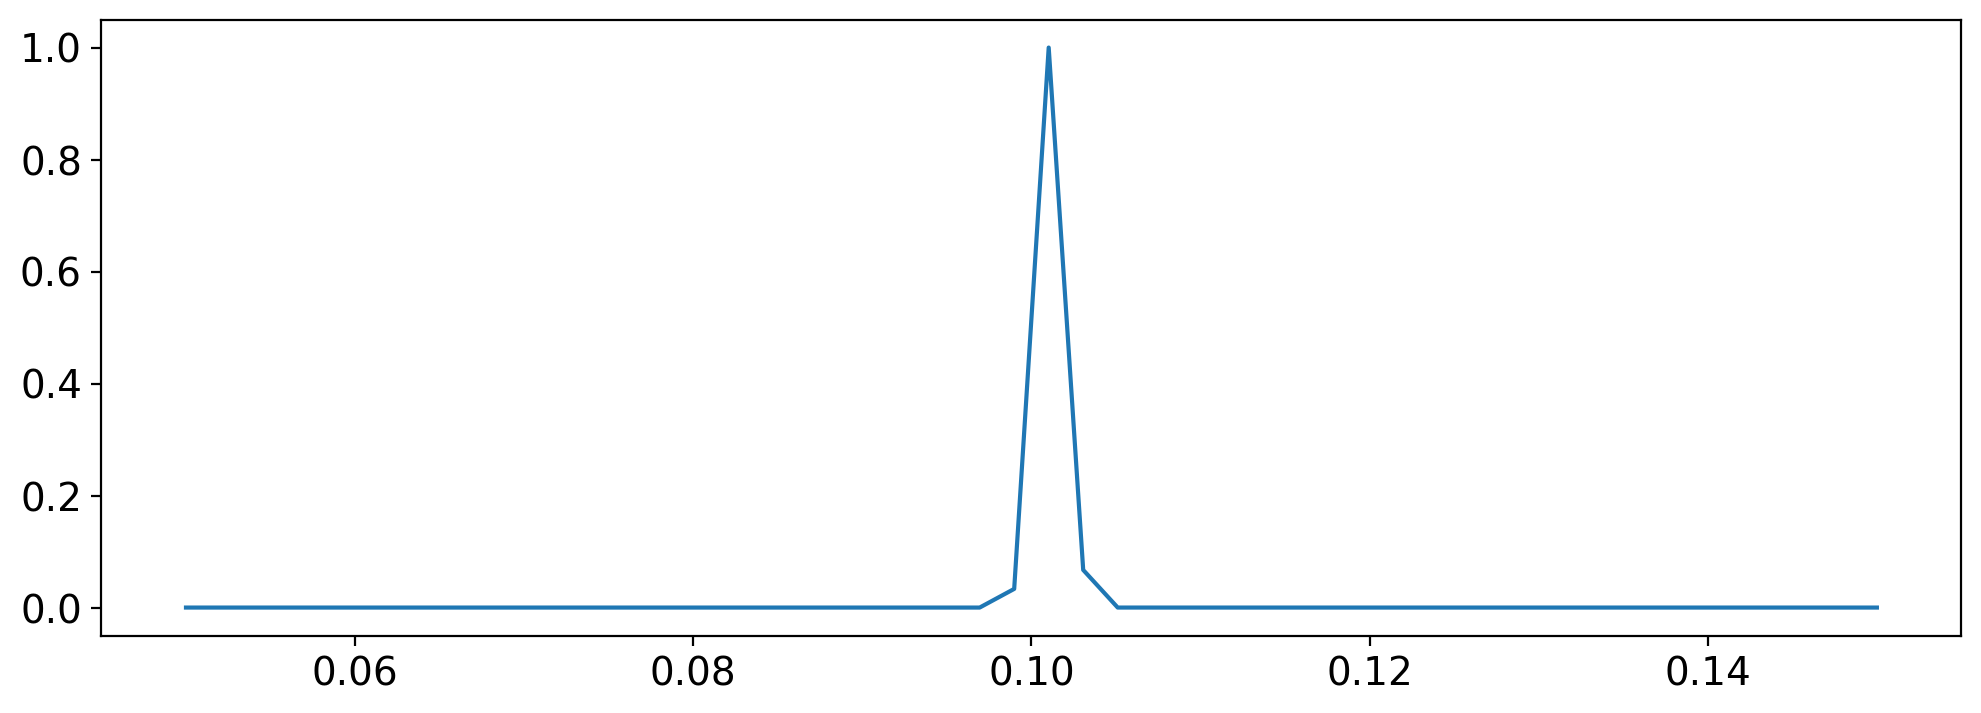

In [293]:
plt.plot(alpha, np.exp(lnlike - np.max(lnlike)))